<a href="https://colab.research.google.com/github/eafpres/DFT_analysis/blob/master/DFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using the Discrete Fourier Transform to Imporve Time Series Forecasts

Suppose we have a time series we would like to forecast, such as the data shown here:

![](https://drive.google.com/uc?id=1TuCTHEoFTP53GVnR3tACzpNUV1SV7mUJ)

It's clear there are periodic behaviors occuring in these data.  We could try to model this in any number of ways; I like to try multiple least squares as well as use artificial neural netwroks (ANNs) to tackle such problems.  To do so with MLS or a fully conencted ANN generally requires having some additional predictor variables other than, say, just a time lagged version of the target data.  A simple example would be to add time variables so that any trend with time could be automatically modeled.  In addition, these data have repeating zeros (the original data were sales data, and no sales occurred on weekends).  I typically add binary variables like "weekend" which would be 1 on weekends and 0 otherwise, to help the model understand that behavior.  Similarly, we might add the month number, week number etc. (or possible a cosine transform of them, so that 1 is "close" to 12, 52 is close to 1, etc.).

Another method I use is to analyze the data using a Discrete Fourier Transform (DFT) to find the "frequencies" or periods that might be hidden in the data and could be used to improve the model.  You don't really need to completely understand the DFT to use this approach, but there are many references available on the internet if you want to learn (Google things like 'Discrete Fourier Transform' or "Signal Analysis' to find more).  First, you can consider that the DFT is based on the concept that any arbitrary waveform can be decomposed into an infinite series of sine and cosine functions.  The continuous Fourier Transform is actually an integral from minus infinity to infinity; the DFT uses uniformly spaced "samples" of the data and some finite set of functions to approximate the data.  However, we aren't typically trying to use enough functions to perfectly fit the data; that would overfit and lead to very poor extrapolation to future predictions.  More on this in a moment.

Next, if we know a data set contains a period, say, 30 days, how do we use that?  To do so, we use the mathematical fact that any given sinusoid at some unknown time offset ("phase" in signal analysis) can be represented by a linear combination of a sine and cosine function at the given period.  The coefficients on the sine and cosine functions determine the time offset and the scale ("amplitude" in signal analysis).  We will find those coefficients by regression or using an ANN.

More or less, that's all you need to know.  Here, I provide a function which uses the DFT built into numpy and the peak find built into scipy.  When you use this function, you can set a threshold to determine how many peaks (each peak is a period found by the DFT) are returned, and it shows a plot labeled with the returned periods.  The function allows you to designate the time unit for one step in the data, so that if you were getting data, say, every hour, and your units were in days, the time unit would be 0.04167 days.  This ensures the results returned are in your units.  Note that a requirement of the DFT is the data are uniformly spaced.

If this is confusing, let's simplify with a basic walk-through:  
1) Start with data in uniform time steps, either time, value or just value  
2) If no time varaible, determine the time step as noted earlier  
3) Call the get_dft function which returns a list of the time periods  
4) For each period you want to use in the model, calculate:  
&nbsp;&nbsp;&nbsp;&nbsp; 4.1) sin(2 * pi * time / period)  
&nbsp;&nbsp;&nbsp;&nbsp; 4.2) cos(2 * pi * time / period)  
where time is the value of time for a given row of data, and period is the value returned from the get_dft function  
5) Add the two series as columns in the "X" data for your model  
6) Fit the model using whatever regression or modeling method you want

Here we'll run a couple of exmaples to demonstrate.  First, we create a complex time series by combining three sine series at different periods, then try to discover those periods with the DFT and finally fit the data with a multiple linear regression model.  Second, for illustration, we create a triangle wave then try to fit that using the DFT results.



## Load modules

In [0]:
import pandas as pd
import numpy as np
from scipy.signal import sawtooth
import statsmodels.api as sm
import math
from datetime import datetime
import calendar
import matplotlib.pyplot as plt

## Define DFT function

In [0]:
def get_dft(data, dt = None, 
            x_limits = None, peak_height_ratio_threshold = None):
#
    """
    function to take the discrete fourier transform of a series
    the series is assumed to be data = pd.DataFrame(x = [x1, x2, ..., xn],
                                                    y = [y1, y2, ..., yn])
    where x is time and y are the series values
    if x is provided and dt is not provided, then the time step
    is calculated as the average delta x over the given data
    otherwise dt is used as the time step; if dt is not given
    and x is not given an exception is raised
    
    if no y data are provided an exception is raised
    
    a basic visualization is given in the time
    space to show the peaks found vs period
    
    if no limits are given for the plot, an exception is raised
    
    if peak_height_ratio_threshold is given the it is used to find
    peaks by setting the lowest height to the produce of 
    peak_height_ratio_threshold times the max y value in the dft
    otherwise a default peak find is used
    
    ---
    
    data:                           pd.DataFrame or pd.Series
    dt:                             int or float (will coerce to float)
    x_limits:                       list of x_min, x_max
    peak_height_ratio_threshold:    float
    
    ---
    
    return value:                   list of periods of peaks
    """
#
    from scipy.signal import find_peaks
    import warnings
#
    class get_dft_error(Exception):
        pass
#    
    x = None
    y = None
    try:
        x = data.iloc[:, 0]
        y = data.iloc[:, 1]
    except:
        try:
            y = data.iloc[:, 0]
        except:
            y = data
    if x is None:
        if dt is None:
            raise get_dft_error('no x (time) data or delta t given')
    elif dt is None:
        dt = np.mean([x[i+1] - x[i] for i in list(range(0, x.shape[0] - 1))])
    if y is None:
        raise get_dft_error('no y data provided')
    if x_limits is None:
        raise get_dft_error('missing limits for peaks vs. period plot')
#
    real_fft = np.abs(np.fft.rfft(y))
    frequencies = np.fft.fftfreq(y.shape[0])[0:real_fft.shape[0]]
#
# ignore the divide by zero error due to the 0 frequency (DC term)
#
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        periods = dt / (frequencies)
#
    if peak_height_ratio_threshold is None:
        raw_peaks = find_peaks(real_fft, height = 0)
    else:
        raw_peaks = \
            find_peaks(real_fft,
                       height = peak_height_ratio_threshold * max(real_fft))
    peak_values = pd.Series(raw_peaks[1]['peak_heights'])
    peak_locs = pd.Series(periods[raw_peaks[0]])
    peak_locs = pd.Series([peak_locs[i] + dt for i in peak_locs.index])
    peak_labels = [str(round(peak_locs[i], 1)) for i in peak_locs.index]
#
    plt.style.use('dark_background')
    plot = plt.figure(figsize = (12, 8))
    ax = plot.add_subplot(111)
    ax.plot(periods,
            real_fft,
            color = "blue")
    ax.set_xlim(x_limits)
    for i in peak_values.index:
        if peak_locs[i] < x_limits[1]:
            ax.text(peak_locs[i], peak_values[i], peak_labels[i])
    plt.show()
    plt.close()
    return peak_locs

In [0]:
class get_dft_error(Exception):
    pass 

## Demonstrate with a multi-frequency synthetic series

<bound method NDFrame.head of 0      0.000000
1      0.346451
2      0.685341
3      1.009317
4      1.311440
         ...   
995   -0.774581
996   -0.844863
997   -0.918947
998   -0.992824
999   -1.062408
Length: 1000, dtype: float64>


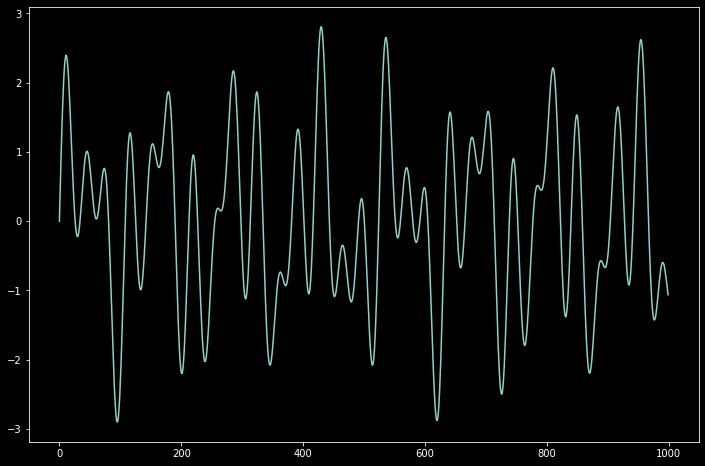

In [0]:
#
# demo with multi-frequency synthetic series
#
my_period = 35
#
# we generate data at my_period and my_period * 1.5, 3.7
# so the periods are 35, 52.5, and 129.5
#
test_data_1 = (pd.Series(np.array(list(range(0, 1000))) * 
                         2 * math.pi / my_period)).apply(math.sin)
test_data_2 = (pd.Series(np.array(list(range(0, 1000))) * 
                         2 * math.pi / (my_period * 1.5))).apply(math.sin)
test_data_3 = (pd.Series(np.array(list(range(0, 1000))) * 
                         2 * math.pi / (my_period * 3.7))).apply(math.sin)
test_data = np.add(np.add(test_data_1, test_data_2), test_data_3)
print(test_data.head)
plt.style.use('dark_background')
plot = plt.figure(figsize = (12, 8))
ax = plot.add_subplot(111)
ax.plot(test_data)
plt.show()
plt.close()

Here is where we put in the "time" mentioned in the introduction.  We could also just send the series to the function and specify the dt value of 1.

In [0]:
#
# add the time variable which is just integer values in this case
#
data = pd.concat((pd.Series(test_data.index).rename('x'), 
                  test_data.rename('y')), axis = 1)
data

,x,y
0,0,0.000000
1,1,0.346451
2,2,0.685341
3,3,1.009317
4,4,1.311440
...,...,...
995,995,-0.774581
996,996,-0.844863
997,997,-0.918947
998,998,-0.992824


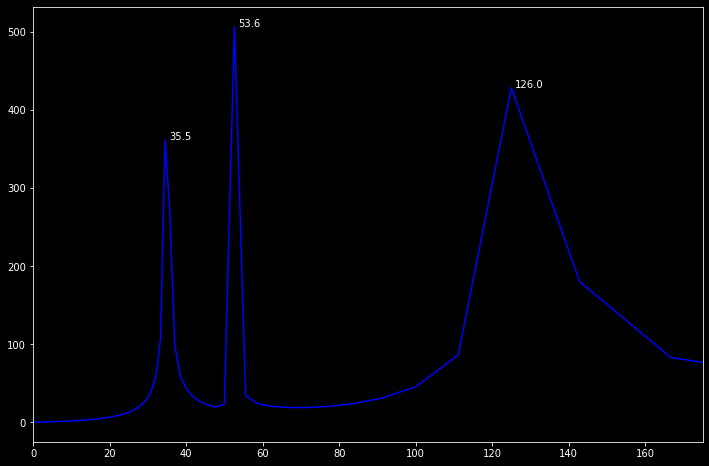

0    126.000000
1     53.631579
2     35.482759
dtype: float64


In [0]:
#
# now get the discrete transform
# x_limits is required by our get_dft function
#
x_limits = [0, my_period * 5]
try:
    my_peaks = get_dft(data = data, x_limits = x_limits,
                       peak_height_ratio_threshold = 0.001)
except get_dft_error as err_msg:
    print(err_msg.message)
#
print(my_peaks)

We see that we found periods of 35.5, 53.6, and 126 vs. the known values of 35, 52.5, and 129.5

This is due to fact that we are sampling at intervals of one but have fractional periods.  Ideally we would "sample" more often, however in business data we generally have to take what we get.  

Also note that in this case, even if we did not set a peak height threshold, we would always return only 3 peaks becuase the series is constructed from 3 pure frequencies.

In [0]:
#
# we add sin and cos series to our data using the found periods
#
model_periods = pd.Series(my_peaks)
period_names = ['cos_' + str(round(model_periods[i], 3)) 
                for i in model_periods.index]
period_names = (period_names +
                ['sin_' + str(round(model_periods[i], 3)) 
                for i in model_periods.index])
period_names

['cos_126.0',
 'cos_53.632',
 'cos_35.483',
 'sin_126.0',
 'sin_53.632',
 'sin_35.483']

In [0]:
for j in range(len(model_periods)):
    data = pd.concat((data, 
                     pd.Series([math.sin(2 * math.pi * i / model_periods[j]) 
                      for i in data.iloc[:, 0]]).rename(period_names[j])),
                     axis = 1)
    data = \
      pd.concat((data,
        pd.Series([math.cos(2 * math.pi * i / model_periods[j]) 
        for i in data.iloc[:, 0]]).rename(period_names[j + len(model_periods)])),
        axis = 1)
data 

,x,y,cos_126.0,sin_126.0,cos_53.632,sin_53.632,cos_35.483,sin_35.483
0,0,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,1,0.346451,0.049846,0.998757,0.116887,0.993145,0.176153,0.984363
2,2,0.685341,0.099568,0.995031,0.232171,0.972675,0.346797,0.937940
3,3,1.009317,0.149042,0.988831,0.344272,0.938870,0.506595,0.862184
4,4,1.311440,0.198146,0.980172,0.451654,0.892193,0.650550,0.759463
...,...,...,...,...,...,...,...,...
995,995,-0.774581,-0.603804,0.797133,-0.323932,-0.946080,0.259556,0.965728
996,996,-0.844863,-0.563320,0.826239,-0.432296,-0.901732,0.425614,0.904905
997,997,-0.918947,-0.521435,0.853291,-0.534733,-0.845021,0.578360,0.815782
998,998,-0.992824,-0.478254,0.878222,-0.629839,-0.776725,0.713019,0.701145


Note that for convenience, we format the column names to no more than 3 decimal places.

## Perform linear regression

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


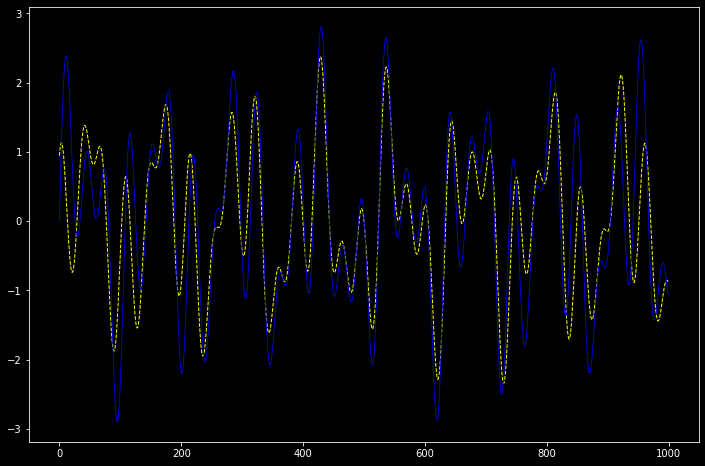

In [0]:
#
# divide data in to X and Y for linear regression
#    
X = data.drop(('y'), axis = 1)
Y = pd.DataFrame(data.y)
#
# fit a multiple least squares model model
#
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
model.summary()
y_pred = model.predict(X)
plt.style.use('dark_background')
plot = plt.figure(figsize = (12, 8))
ax = plot.add_subplot(111)
ax.plot(data.x, y_pred,
        color = "yellow",
        lw = 1, 
        linestyle = 'dashed')
ax.plot(data.x, data.y,
        color = "blue",
        lw = 0.75)
plot.show()

The least squares fit to our 3 found periods does a pretty good job reconstructing the original series.

## Demonstrate with a Triangle wave form data set

In [0]:
#
# construct a triangle wave
#
x = pd.Series(np.arange(0, 110, 0.1))
A = 1
P = 22 
y = pd.Series(sawtooth(x, 0.5))
x = pd.Series(x.multiply(P / (2 * math.pi)))
data = pd.concat((x.rename('x'), y.rename('y')), axis = 1)
data

,x,y
0,0.000000,-1.000000
1,0.350141,-0.936338
2,0.700282,-0.872676
3,1.050423,-0.809014
4,1.400563,-0.745352
...,...,...
1095,383.404258,0.709865
1096,383.754399,0.773527
1097,384.104540,0.837189
1098,384.454681,0.900851


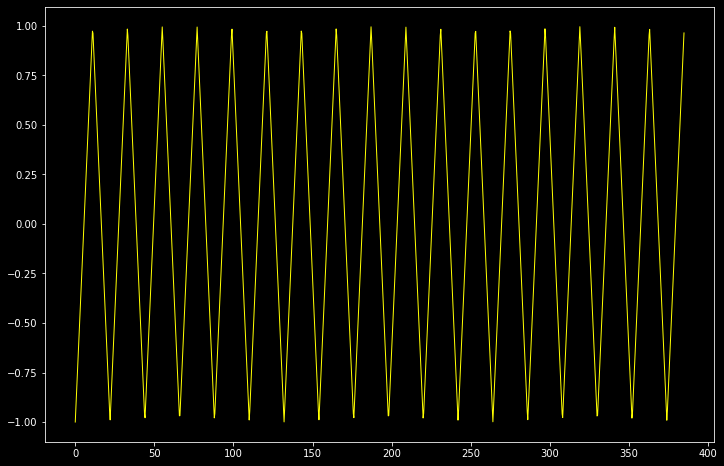

In [0]:
plt.style.use('dark_background')
plot = plt.figure(figsize = (12, 8))
ax = plot.add_subplot(111)
ax.plot(x, y,
        color = "yellow",
        lw = 1, 
        linestyle = 'solid')
plot.show()

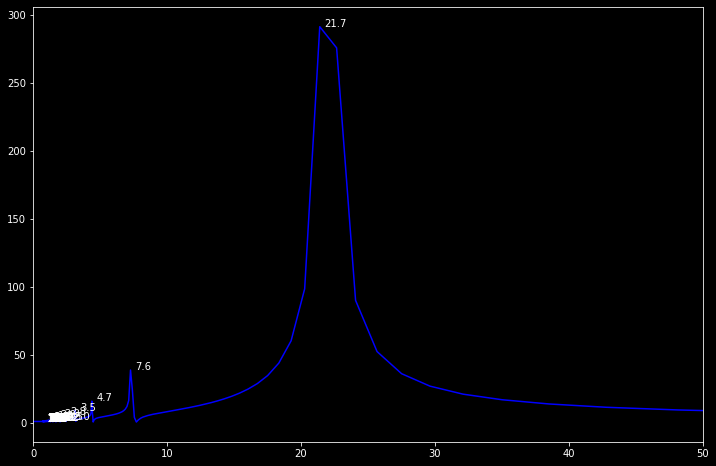

0     21.747639
1      7.617216
2      4.726902
3      3.481482
4      3.043532
        ...    
75     1.075480
76     1.071405
77     1.067375
78     1.059450
79     1.051698
Length: 80, dtype: float64
['cos_21.748', 'cos_7.617', 'cos_4.727', 'cos_3.481', 'cos_3.044', 'cos_2.788', 'cos_2.514', 'cos_2.346', 'cos_2.211', 'cos_2.158', 'cos_2.085', 'cos_2.039', 'cos_1.942', 'cos_1.903', 'cos_1.849', 'cos_1.815', 'cos_1.741', 'cos_1.711', 'cos_1.697', 'cos_1.683', 'cos_1.669', 'cos_1.643', 'cos_1.617', 'cos_1.585', 'cos_1.577', 'cos_1.561', 'cos_1.55', 'cos_1.539', 'cos_1.528', 'cos_1.507', 'cos_1.486', 'cos_1.46', 'cos_1.451', 'cos_1.441', 'cos_1.432', 'cos_1.423', 'cos_1.414', 'cos_1.397', 'cos_1.38', 'cos_1.358', 'cos_1.351', 'cos_1.343', 'cos_1.335', 'cos_1.328', 'cos_1.32', 'cos_1.306', 'cos_1.292', 'cos_1.274', 'cos_1.267', 'cos_1.261', 'cos_1.254', 'cos_1.248', 'cos_1.242', 'cos_1.229', 'cos_1.218', 'cos_1.202', 'cos_1.197', 'cos_1.191', 'cos_1.186', 'cos_1.18', 'cos_1.175', 'cos_1.

In [0]:
try:
    my_peaks = get_dft(data, x_limits = [0, 50], 
                       peak_height_ratio_threshold = 0.001)
except get_dft_error as err_msg:
    print(err_msg.msg)
print(my_peaks)
#
model_periods = pd.Series(my_peaks)
period_names = ['cos_' + str(round(model_periods[i], 3)) 
                for i in model_periods.index]
period_names = (period_names +
                ['sin_' + str(round(model_periods[i], 3)) 
                for i in model_periods.index])
print(period_names)

In [0]:
#
# add the sin / cos series to the data
#
for j in range(len(model_periods)):
    data = pd.concat((data, 
                     pd.Series([math.sin(2 * math.pi * i / model_periods[j]) 
                      for i in data.iloc[:, 0]]).rename(period_names[j])),
                     axis = 1)
    data = pd.concat((data,
                     pd.Series([math.cos(2 * math.pi * i / model_periods[j]) 
                      for i in data.iloc[:, 0]]).rename(period_names[j + len(model_periods)])),
                     axis = 1)
data

,x,y,cos_21.748,sin_21.748,cos_7.617,sin_7.617,cos_4.727,sin_4.727,cos_3.481,sin_3.481,cos_3.044,sin_3.044,cos_2.788,sin_2.788,cos_2.514,sin_2.514,cos_2.346,sin_2.346,cos_2.211,sin_2.211,cos_2.158,sin_2.158,cos_2.085,sin_2.085,cos_2.039,sin_2.039,cos_1.942,sin_1.942,cos_1.903,sin_1.903,cos_1.849,sin_1.849,cos_1.815,sin_1.815,cos_1.741,sin_1.741,cos_1.711,sin_1.711,cos_1.697,sin_1.697,...,cos_1.175,sin_1.175,cos_1.164,sin_1.164,cos_1.154,sin_1.154,cos_1.151,sin_1.151,cos_1.141,sin_1.141,cos_1.136,sin_1.136,cos_1.131,sin_1.131,cos_1.127,sin_1.127,cos_1.122,sin_1.122,cos_1.117,sin_1.117,cos_1.108,sin_1.108,cos_1.099,sin_1.099,cos_1.097,sin_1.097,cos_1.088,sin_1.088,cos_1.08,sin_1.08,cos_1.075,sin_1.075,cos_1.071,sin_1.071,cos_1.067,sin_1.067,cos_1.059,sin_1.059,cos_1.052,sin_1.052
0,0.000000,-1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000e+00,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,0.350141,-0.936338,0.100988,0.994888,0.284821,0.958581,0.448799,0.893633,0.590691,0.806898,0.661520,0.749927,0.709751,0.704453,0.767622,0.640903,0.806295,0.591514,0.838823,0.544404,0.851733,0.523977,0.869959,0.493124,0.881363,0.472440,9.057023e-01,0.423914,0.915181,0.403043,0.928355,0.371695,0.936455,0.350789,0.953287,0.302065,0.959638,0.281237,0.962624,0.270840,...,0.954824,-0.297172,0.949690,-0.313193,0.944328,-0.329004,0.942492,-0.334228,0.936840,-0.349759,0.933934,-0.357445,0.930977,-0.365079,0.927968,-0.372659,0.924910,-0.380186,0.921802,-0.387660,0.915443,-0.402449,0.908895,-0.417024,0.906673,-0.421835,0.899886,-0.436126,0.892926,-0.450204,0.889383,-0.457163,0.885799,-0.464068,0.882176,-0.470921,0.874810,-0.484466,0.867293,-0.497799
2,0.700282,-0.872676,0.200943,0.979603,0.546047,0.837754,0.802123,0.597159,0.953255,0.302169,0.992184,0.124782,0.999972,-0.007492,0.983942,-0.178488,0.953869,-0.300223,0.913317,-0.407249,0.892576,-0.450897,0.857996,-0.513657,0.832782,-0.553602,7.678804e-01,-0.640593,0.737715,-0.675113,0.690130,-0.723686,0.656996,-0.753894,0.575910,-0.817513,0.539772,-0.841811,0.521435,-0.853291,...,-0.567493,-0.823378,-0.594872,-0.803821,-0.621376,-0.783512,-0.630015,-0.776583,-0.655337,-0.755337,-0.667661,-0.744465,-0.679760,-0.733435,-0.691632,-0.722251,-0.703276,-0.710917,-0.714692,-0.699439,-0.736837,-0.676070,-0.758062,-0.652182,-0.764933,-0.644110,-0.784927,-0.619588,-0.803997,-0.594633,-0.813185,-0.582005,-0.822143,-0.569281,-0.830869,-0.556467,-0.847631,-0.530586,-0.863474,-0.504393
3,1.050423,-0.809014,0.298844,0.954302,0.762040,0.647529,0.984808,0.173648,0.947667,-0.319260,0.826611,-0.562773,0.699116,-0.715008,0.493600,-0.869689,0.322158,-0.946686,0.155603,-0.987820,0.083646,-0.996496,-0.023762,-0.999718,-0.094485,-0.995526,-2.546711e-01,-0.967028,-0.320520,-0.947242,-0.415319,-0.909676,-0.475521,-0.879705,-0.605362,-0.795950,-0.656030,-0.754734,-0.680173,-0.733052,...,-0.617538,0.786541,-0.577070,0.816694,-0.535457,0.844562,-0.521354,0.853340,-0.478420,0.878131,-0.456629,0.889657,-0.434645,0.900602,-0.412483,0.910965,-0.390158,0.920748,-0.367687,0.929950,-0.322364,0.946616,-0.276635,0.960975,-0.261322,0.965252,-0.215231,0.976563,-0.169001,0.985616,-0.145867,0.989304,-0.122739,0.992439,-0.099628,0.995025,-0.053513,0.998567,-0.007621,0.999971
4,1.400563,-0.745352,0.393689,0.919244,0.914907,0.403664,0.957990,-0.286803,0.576087,-0.817388,0.247613,-0.968859,-0.014983,-0.999888,-0.351243,-0.936284,-0.572747,-0.8

For illustration, first we use just the largest peak from the DFT.  Note below that we are using only three cycles of the data for the fit.

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


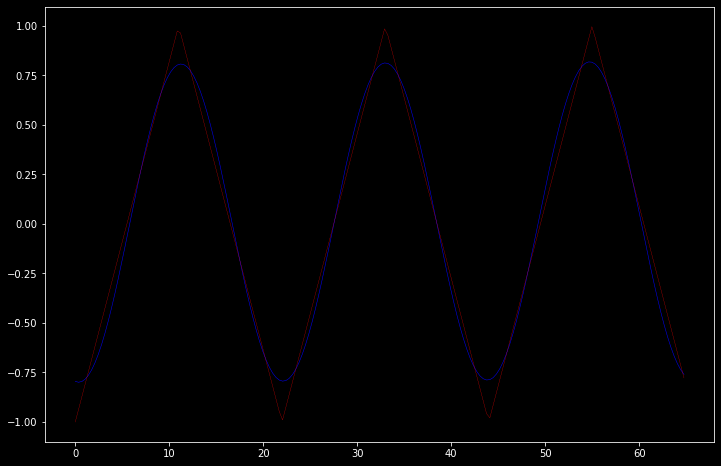

In [0]:
# 
# first we'll fit using only the primary frequency
#
dt = data.x[1] - data.x[0]
X = data[['x', 'sin_21.748', 'cos_21.748']].iloc[0:int(3 * max(model_periods) / dt), :]
Y = data.y[0:int(3 * max(model_periods) / dt)]
#
# fit a MLS model
#
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
model.summary()
y_pred = model.predict(X)
plot = plt.figure(figsize = (12, 8))
ax = plot.add_subplot(111)
ax.plot(X.x, y_pred,
        color = "blue",
        lw = 0.75)
ax.plot(X.x, Y,
        color = "red",
        lw = 0.75)
plot.show()

Note that we are getting most of the form, but as a sine wave.  Now we repeat the fit using all the frequencies we found to see the improvement in the fit.

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


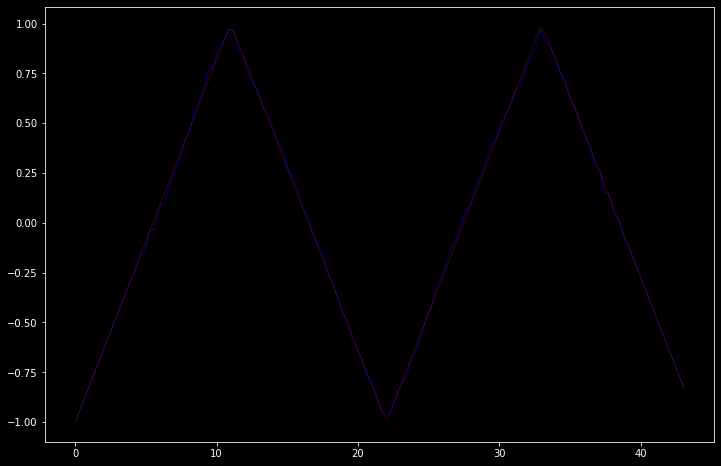

In [0]:
#
# repeat with all the frequencies
#
X = data.drop(('y'), axis = 1).iloc[0:int(2 * max(model_periods) / dt), :]
Y = data.y[0:int(2 * max(model_periods) / dt)]
#
# fit a MLS model
#
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
model.summary()
y_pred = model.predict(X)
plot = plt.figure(figsize = (12, 8))
ax = plot.add_subplot(111)
ax.plot(X.x, y_pred,
        color = "blue",
        lw = 0.75)
ax.plot(X.x, Y,
        color = "red",
        lw = 0.75)
plot.show()

Now we are reproducing almost a perfect triangle wave.  

##Important  

In a time series modeling case, you would NOT want to use so many functions (added columns) because it would severly overfit to the range of the data and simply repeat outside of it, and therefore would lack any power to generalize.  You should only use terms which make sense and consdier testing the best choices using cross validation.  

##Conclusion  

We've seen that using the Discrete Fourier Transform we can discover repeating periods in time series, and can use these in sine / cosine series pairs as additional predictors (x values) in a model.  Used in analysis of business data for forecasting this can provide significant improvement. The main drawback is the potential for over-fitting.